In [1]:
from matplotlib.pyplot import thetagrids
import h5py
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn import metrics

from tqdm import tqdm

from dask import delayed, compute
from dask.diagnostics import ProgressBar

pd.options.mode.chained_assignment = None

In [2]:
site = 'BARR'
file_path = f'/media/data/NEON/{site}/filesToStack00200'
files = [os.path.join(file_path, f) for f in os.listdir(file_path) if '.h5' in f]
save_path = f'/media/data/NEON/{site}/observations/nsae.csv'

This notebook selects observations based on completeness of data then samples from them using two level stratification; first by wind direction sector, then by footprint calculation input parameters.


Below we define some functions for later use.  The docstring describe what they do.  The function `find_sectors()` will be used to evenly sample from different wind directions. 

In [5]:
def find_valid_observations(f):
    '''
    Reads footprint statistics from f,
    drops bad observations,
    then returns dataframe.
    '''
    # open the hdf
    hdf = pd.HDFStore(f)

    # get the flux quality flags
    qfqm_CO2 = hdf.get(f'{site}/dp04/qfqm/fluxCo2/nsae')
    qfqm_H2O = hdf.get(f'{site}/dp04/qfqm/fluxH2o/nsae')
    qfqm_T = hdf.get(f'{site}/dp04/qfqm/fluxTemp/nsae')
    qfqm_foot = hdf.get(f'{site}/dp04/qfqm/foot/turb')

    # Select observations with no bad flags
    qfqm_CO2  = qfqm_CO2.loc[qfqm_CO2.qfFinl == 0]
    qfqm_H2O  = qfqm_H2O.loc[qfqm_H2O.qfFinl == 0]
    qfqm_T    = qfqm_T.loc[qfqm_T.qfFinl == 0]
    qfqm_foot = qfqm_foot.loc[qfqm_foot.qfFinl == 0]

    # get the footprint input stats
    stat = hdf.get(f'{site}/dp04/data/foot/stat/')

    # get indices of the dfs from above
    istat  = stat.set_index('timeBgn').index
    iqfqmC = qfqm_CO2.set_index('timeBgn').index
    iqfqmH = qfqm_H2O.set_index('timeBgn').index
    iqfqmT = qfqm_T.set_index('timeBgn').index
    iqfqmf = qfqm_foot.set_index('timeBgn').index

    # keep only entries in stat which correspond to good
    # qfqm flags for all variables
    good = stat[
        (istat.isin(iqfqmC)) &
        (istat.isin(iqfqmH)) &
        (istat.isin(iqfqmT)) &
        (istat.isin(iqfqmf))
    ]

    hdf.close()

    return good


def find_sectors(stat, theta=10):
    '''
    Returns a df of timestamps and sectors of the mean wind direction
    '''

    # make sure theta goes into 360 an even number of times
    if 360 % theta != 0:
        while 360 % theta != 0:
            theta= theta + 1
        print(f'theta has been forced to {theta} for even division of 360')

    # set start angle, and empy list
    stat['sector'] = theta * (stat.angZaxsErth // theta)

    return stat


def gmm_cluster(df,k_range=(2, 10), verbose=True):
    '''
    Performs Gaussian Mixture Model clustering.
    df - dataframe containing only the features to
         be used in clustering
    k_range - tuple, representing range of numbers
         of clusters to be tried.
    '''
    # empty list
    silhouette_scores  = []

    # make list of range
    k_r = list(range(*k_range))

    for k in k_r:
        # make model
        model = GaussianMixture(n_components=k,
                                n_init=10,
                                init_params='kmeans')
        # fit
        labels = model.fit_predict(df)

        # calculate silhouette score
        silhouette_scores.append(
            metrics.silhouette_score(df, labels, metric='euclidean')
            )

        # choose the highest silhouette scoring k
        k = k_r[np.argmax(silhouette_scores)]

    # now create full model
    modelk = GaussianMixture(
        n_components=k,
        covariance_type='full',
        random_state=1
        )

    cluster = modelk.fit(df)
    labels = modelk.predict(df)

    if verbose:
        print(f'*************** {k} Cluster Model ***************')
        print('Weights: ', cluster.weights_)
        print('Converged: ', cluster.converged_)
        print(' No. of Iterations: ', cluster.n_iter_)
        print('Lower Bound: ', cluster.lower_bound_)
        print(f'*************************************************')

    return labels


def fetch_by_sector(files, sector, theta):
    '''
    Merges footprint stats and nsae observations, performs qc check,
    returns df of observations for a given sector.
     
    sectors is a list or 1d array of sectors
    '''

    sect_dfs = []

    for f in files:
            # open the hdf
        hdf = pd.HDFStore(f)

        # get the flux quality flags
        qfqm_CO2 = hdf.get(f'{site}/dp04/qfqm/fluxCo2/nsae')
        qfqm_H2O = hdf.get(f'{site}/dp04/qfqm/fluxH2o/nsae')
        qfqm_T = hdf.get(f'{site}/dp04/qfqm/fluxTemp/nsae')
        qfqm_foot = hdf.get(f'{site}/dp04/qfqm/foot/turb')

        # Select observations with no bad flags
        qfqm_CO2  = qfqm_CO2.loc[qfqm_CO2.qfFinl == 0]
        qfqm_H2O  = qfqm_H2O.loc[qfqm_H2O.qfFinl == 0]
        qfqm_T    = qfqm_T.loc[qfqm_T.qfFinl == 0]
        qfqm_foot = qfqm_foot.loc[qfqm_foot.qfFinl == 0]

        # get the footprint input stats
        stat = hdf.get(f'{site}/dp04/data/foot/stat/')

        # get indices of the dfs from above
        istat  = stat.set_index('timeBgn').index
        iqfqmC = qfqm_CO2.set_index('timeBgn').index
        iqfqmH = qfqm_H2O.set_index('timeBgn').index
        iqfqmT = qfqm_T.set_index('timeBgn').index
        iqfqmf = qfqm_foot.set_index('timeBgn').index

        # keep only entries in stat which correspond to good
        # qfqm flags for all variables
        good = stat.loc[
            (istat.isin(iqfqmC)) &
            (istat.isin(iqfqmH)) &
            (istat.isin(iqfqmT)) &
            (istat.isin(iqfqmf))
        ]

        # find the sectors that exist in this df
        good = find_sectors(good, theta=theta)

        # get fluxes
        flux_CO2 = hdf.get(f'{site}/dp04/data/fluxCo2/nsae')
        flux_H2O = hdf.get(f'{site}/dp04/data/fluxH2o/nsae')
        flux_T   = hdf.get(f'{site}/dp04/data/fluxTemp/nsae')

        # change names of flux columns
        flux_CO2.columns = ['timeBgn', 'timeEnd', 'flux_CO2']
        flux_H2O.columns = ['timeBgn', 'timeEnd', 'flux_H2O']
        flux_T.columns = ['timeBgn', 'timeEnd', 'flux_Temp']

        # drop timeEnd, set index to timeBgn
        flux_CO2 = flux_CO2.drop(columns=['timeEnd']).set_index('timeBgn')
        flux_H2O = flux_H2O.drop(columns=['timeEnd']).set_index('timeBgn')
        flux_T = flux_T.drop(columns=['timeEnd']).set_index('timeBgn')
        good = good.drop(columns=['timeEnd']).set_index('timeBgn')

        # merge dfs
        dfs = [good, flux_CO2, flux_H2O, flux_T]
        data = pd.concat(dfs, axis=1, join='inner')

        if sector in data.sector.unique():
            # group the data by sector
            sect_group = data.groupby('sector')

             # get data for sector
            df = sect_group.get_group(sector)

            # stick it on the list
            sect_dfs.append(df)

        else:
            pass

    # concat data from all files pertaining to sector
    df = pd.concat(sect_dfs)

    # drop rows with nulls
    df = df.dropna()

    hdf.close()

    return df


In [6]:
# degrees per sector
θ = 18

# make empty df
sectors = pd.DataFrame(columns=['timeBgn', 'sector'])

# fill df with timestamps and sectors of valid observations
for f in files:
    # find footprint stats of the valid observations
    stat = find_valid_observations(f)

    # find sectors in which observations lie
    sects = find_sectors(stat, theta=θ)

    # scrunch the latest observations onto the df
    sectors = pd.concat([sectors, sects], axis=0)

In [5]:
# empty list
df_list = []

# get the sectors
sc = sectors.sector.unique()
sc.sort()

# for each sector (this cannot be || because hdfs are open)
for s in tqdm(sc):
    
    # append df for that sector to list 
    df_list.append(fetch_by_sector(files, s , θ))

# concat the list and cluster
df = pd.concat(df_list, axis=0)

# columns to use in clustering
cols = ['veloYaxsHorSd',
'veloZaxsHorSd',
'veloFric',
'distZaxsMeasDisp',
'distZaxsRgh',
'distZaxsAbl',
'distXaxs90',
'distXaxsMax', 
'distYaxs90']

# now cluster based on footprint inputs, and note n clusters
df['label'] = gmm_cluster(df[cols])
n_clust = df.label.unique().shape[0]


0it [00:00, ?it/s]


ValueError: No objects to concatenate

In [ ]:
# look at some of smallest sector counts
sectors.sector.value_counts().sort_values().head(10)

18.0      9
72.0     14
108.0    16
90.0     17
0.0      21
36.0     22
54.0     23
342.0    23
126.0    32
324.0    38
Name: sector, dtype: int64

Looking at the above output we can see that there is descent representation across sectors. Let's choose 20 as a sample size from each sector. There will be three underrepresented sectors, but they will not be hugely underrepresented.

In [ ]:
# number of samples
n_samples = 20

# function to go in dask loop to get samples
@delayed()
def lil_func(s, sector_groups):
    ddd = []

    d = sector_groups.get_group(s)

    # find the smallest cluseter count in d
    x = np.inf
    for i in range(n_clust):
        x = min(x, len(d.loc[d.label == i]))
        # now many to take from each cluster
        n_s = min(n_samples // 2, x)
    
    # sample from each cluster
    for i in range(n_clust):
        ddd.append(d.loc[d.label == i].sample(n_s))
    d = pd.concat(ddd, axis=0)
    return d

# now bust the df up by sector again
sector_groups = df.groupby('sector')

# for each sector
lazy = []
for s in tqdm(sc):
    lazy.append(lil_func(s, sector_groups))

with ProgressBar():

    to_concat = compute(*lazy)

    d = pd.concat(to_concat, axis=0)



100%|██████████| 20/20 [00:00<00:00, 15363.75it/s]

[########################################] | 100% Completed |  0.1s


In [ ]:
d

,angZaxsErth,distReso,veloYaxsHorSd,veloZaxsHorSd,veloFric,distZaxsMeasDisp,distZaxsRgh,distZaxsAbl,distXaxs90,distXaxsMax,distYaxs90,sector,flux_CO2,flux_H2O,flux_Temp,label
timeBgn,,,,,,,,,,,,,,,,
2019-09-04T01:30:00.000Z,33.300662,40.0,0.987935,0.547851,0.413994,42.41,3.882275,1000.0,560.0,280.0,240.0,18.0,3.881349,57.971081,-38.694133,0
2019-08-30T03:30:00.000Z,22.813947,40.0,0.315621,0.230000,0.200000,42.41,4.241000,1000.0,600.0,280.0,200.0,18.0,2.401831,-20.109489,-26.950858,1
2019-08-23T15:30:00.000Z,38.385578,40.0,0.416736,0.321403,0.215207,42.41,4.241000,1000.0,520.0,240.0,200.0,36.0,-13.989782,185.337514,137.965709,0
2019-09-24T06:00:00.000Z,50.010893,40.0,0.540548,0.230000,0.200000,42.41,2.503394,1000.0,760.0,320.0,320.0,36.0,-5.419283,-0.765701,2.163597,1
2019-09-05T20:00:00.000Z,85.135861,40.0,1.207982,0.680086,0.672338,42.41,4.241000,1000.0,680.0,280.0,280.0,72.0,-8.367664,251.247036,179.738166,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-24T11:30:00.000Z,337.174517,40.0,0.359577,0.230000,0.200000,42.41,0.965674,1000.0,1000.0,440.0,200.0,324.0,0.074285,2.722504,-9.942192,1
2019-10-25T04:00:00.000Z,324.195835,40.0,0.373068,0.230000,0.200000,42.41,0.088155,1000.0,1640.0,640.0,200.0,324.0,3.449447,-21.971639,-11.122484,1
2019-07-05T08:00:00.000Z,325.018644,40.0,0.465912,0.230000,0.200000,42.41,4.241000,1000.0,600.0,280.0,320.0,324.0,0.976421,-10.823095,-3.762834,1


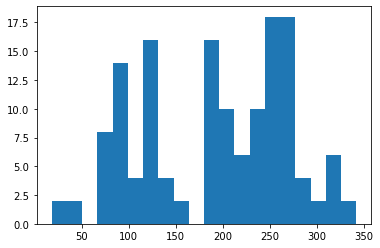

In [ ]:
plt.hist(d.sector.values, bins=sc.shape[0]);

In [ ]:
# save the  data, not big, just use csv
d.to_csv(save_path)
